# Running Different scenarios on Model 1c

In [1]:
# %%
 #pip install gurobipy


In [2]:
# %%
# Import packages
import gurobipy as gp
from gurobipy import nlfunc
from gurobipy import GRB
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt

# ensure results folder
results_folder = "scenario-results"
os.makedirs(results_folder, exist_ok=True)

# model prefix
model_prefix = "1c"


## Data Inputs

In [3]:
# %%

# load JSONs
with open('../data/question_1c/bus_params.json', 'r') as file:
    bus_params = json.load(file)
with open('../data/question_1c/DER_production.json', 'r') as file:
    der_production = json.load(file)
with open('../data/question_1c/appliance_params.json', 'r') as file:
    appl_params= json.load(file)
with open('../data/question_1c/usage_preferences.json', 'r') as file:
    usage_preference= json.load(file)

# Read relevant fields from JSONs

# Lmin_t : minimum hourly flexible load (kWh/h). Lmint = 0 here because the load is fully flexible.
Lmin_t = 0.0
# Lmax_t : maximum hourly flexible load (kWh/h).
Lmax_t = appl_params["load"][0]["max_load_kWh_per_hour"]
# Pt_PV : Hourly available PV production (kWh/h).
Pt_PV = der_production[0]["hourly_profile_ratio"]
# pt: electricity price (DKK/kWh). (will be overwritten per scenario)
pt = bus_params[0]["energy_price_DKK_per_kWh"]

#Lt_ref : reference hourly profile of preferred consumption (kWh).
Lt_ref = usage_preference[0]["load_preferences"][0]["hourly_profile_ratio"] 

#gt_imp_max and gt_exp_max (will be overwritten per scenario)
max_import_kW = bus_params[0]["max_import_kW"]
max_export_kW = bus_params[0]["max_export_kW"]

#tau_imp and tau_export : are the tariffs per hour? (DKK/kWh)
tau_imp = bus_params[0]["import_tariff_DKK/kWh"]
tau_exp = bus_params[0]["export_tariff_DKK/kWh"]

# Battery parameters (DO NOT MODIFY across scenarios)
Emax = appl_params["storage"][0]["storage_capacity_kWh"]
chrg_ratio = appl_params["storage"][0]["max_charging_power_ratio"]
Pt_chrg_max = chrg_ratio * Emax
dischrg_ratio = appl_params["storage"][0][ "max_discharging_power_ratio"]
Pt_dischrg_max = dischrg_ratio * Emax

# ηch, ηdis: charging and discharging efficiencies.
eff_ch = appl_params["storage"][0]["charging_efficiency"]
eff_dis = appl_params["storage"][0]["discharging_efficiency"]

# Other parameters
alpha = 10
n_hours = 24
HOURS = list(range(n_hours))

# Load scenarios (same as 1a)
with open('../data/scenarios.json', 'r') as f:
    scenarios = json.load(f)


## Function: build_and_solve_for_scenario (preserves original constraints & battery params)

In [4]:
# %%

def build_and_solve_for_scenario(scenario, scenario_index, model_prefix=model_prefix):
    """Builds model for a single scenario (keeping battery params unchanged), solves it, saves plots and returns results.
    """
    # overwrite scenario-specific parameters
    pt = scenario["energy_price_DKK_per_kWh"]
    max_import_kW = scenario["max_import_kW"]
    max_export_kW = scenario["max_export_kW"]
    tau_imp = scenario["import_tariff_DKK/kWh"]
    tau_exp = scenario["export_tariff_DKK/kWh"]

    model = gp.Model("Model_1c_s" + str(scenario_index))
    lb = 0.0
    ub = float('inf')

    # Decision variables (battery parameters kept from earlier)
    Lt = {t: model.addVar(Lmin_t, Lmax_t,vtype=GRB.CONTINUOUS, name=f'L{t}') for t in HOURS}
    ut= {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name=f's{t}') for t in HOURS}
    ct = {t: model.addVar(lb, ub,vtype=GRB.CONTINUOUS, name=f'c{t}') for t in HOURS}
    gt_imp = {t: model.addVar(lb, max_import_kW, vtype=GRB.CONTINUOUS, name=f'g{t}_imp') for t in HOURS}
    gt_exp = {t: model.addVar(lb, max_export_kW,vtype=GRB.CONTINUOUS, name=f'g{t}_exp') for t in HOURS}
    HCt = {t: model.addVar(-ub, ub,vtype=GRB.CONTINUOUS, name=f'HC{t}') for t in HOURS}
    Dt = {t: model.addVar(0, ub,vtype=GRB.CONTINUOUS, name=f'D{t}') for t in HOURS}
    bt_ch = {t: model.addVar(0, Pt_chrg_max,vtype=GRB.CONTINUOUS, name=f'b{t}_ch') for t in HOURS}
    bt_dis = {t: model.addVar(0, Pt_dischrg_max,vtype=GRB.CONTINUOUS, name=f'b{t}_dis') for t in HOURS}
    Et = {t: model.addVar(0, Emax,vtype=GRB.CONTINUOUS, name=f'E{t}_bt') for t in HOURS}

    model.update()

    # Constraints
    model.addLConstr(Et[0], GRB.EQUAL , Et[n_hours-1], name='Value E0')
    model.addLConstr(Et[n_hours-1], GRB.GREATER_EQUAL , 0, name='Battery depletetion E24')

    for t in HOURS:
        model.addLConstr(ut[t] + ct[t], GRB.EQUAL , Pt_PV[t], name=f'PV_allocation_{t}')
        model.addLConstr(ut[t] + gt_imp[t] + bt_dis[t], GRB.EQUAL , Lt[t] + gt_exp[t] + bt_ch[t], name=f'Energy_balance_at_node_{t}')
        model.addConstr((pt[t] + tau_imp) * gt_imp[t] - (pt[t] - tau_exp) * gt_exp[t] == HCt[t], name=f'Hourly_cost_{t}')
        # Discomfort via absolute constraints (keeps it linear-ish)
        model.addConstr(Dt[t] >= Lt_ref[t] - Lt[t], name=f'D_abs1_{t}')
        model.addConstr(Dt[t] >= Lt[t] - Lt_ref[t], name=f'D_abs2_{t}')

        if t>0:
            model.addLConstr(bt_ch[t] + Et[t-1], GRB.LESS_EQUAL ,Emax, name=f'Battery_charge_limit_{t}')
            model.addLConstr(Et[t-1] - bt_dis[t], GRB.GREATER_EQUAL , 0, name=f'Battery_Discharge_limit_{t}')
            model.addLConstr(Et[t-1] + eff_ch * bt_ch[t] - eff_dis*bt_dis[t], GRB.EQUAL ,Et[t], name=f'Battery_charge_and_Discharge_{t}')
        else:
            model.addLConstr(bt_ch[t] == 0, name='Battery_charge_limit_0')
            model.addLConstr(bt_dis[t] == 0, name='Battery_Discharge_limit_0')

    model.setObjective(gp.quicksum(alpha * Dt[t] + HCt[t] for t in HOURS), GRB.MINIMIZE)

    model.optimize()

    # Collect results
    primal_obj = None
    dual_obj = None
    if model.status == GRB.OPTIMAL:
        primal_obj = model.ObjVal
        # compute dual objective from available (linear) constraint duals
        dual_sum = 0.0
        for c in model.getConstrs():
            try:
                pi = c.Pi
                rhs = c.RHS
                if pi is not None:
                    dual_sum += rhs * pi
            except Exception:
                pass
        dual_obj = dual_sum

    # Extract values for plotting
    Lt_values = [Lt[t].X for t in HOURS]
    ut_values = [ut[t].X for t in HOURS]
    ct_values = [ct[t].X for t in HOURS]
    gt_imp_values = [gt_imp[t].X for t in HOURS]
    gt_exp_values = [gt_exp[t].X for t in HOURS]
    HCt_values = [HCt[t].X for t in HOURS]
    Et_values = [Et[t].X for t in HOURS]
    bt_ch_values = [bt_ch[t].X for t in HOURS]
    bt_dis_values = [bt_dis[t].X for t in HOURS]

    # Save plots
    scen_num = str(scenario_index+1).zfill(2)
    plot1 = os.path.join(results_folder, f"{model_prefix}-scenario-{scen_num}-AllDecisionVariables.png")
    plt.figure(figsize=(12,6))
    plt.plot(HOURS, Lt_values, label='Load Consumption ($L_t$)', alpha=0.7, marker='o')
    plt.plot(HOURS, ut_values, label='PV not curtailed ($u_t$)', alpha=0.7, marker='s')
    plt.plot(HOURS, ct_values, label='PV Curtailed ($c_t$)', alpha=0.7, marker='^')
    plt.plot(HOURS, gt_imp_values, label='Grid Import ($g_t^{imp}$)', alpha=0.7, marker='x')
    plt.plot(HOURS, gt_exp_values, label='Grid Export ($g_t^{exp}$)', alpha=0.7, marker='D')
    plt.plot(HOURS, Et_values, label='Battery state-of-charge($E_t$)', alpha=0.7)
    plt.plot(HOURS, bt_ch_values, label='Battery charge($...$)', alpha=0.7, marker='s')
    plt.plot(HOURS, bt_dis_values, label='Battery discharge($..$)', alpha=0.7, marker='x')
    plt.plot(HOURS, Pt_PV, label='PV Production ($P_t^{PV}$)', alpha=0.7, marker='*')
    plt.plot(HOURS, Lt_ref, label='reference load consumption($L_t^{ref}$)', alpha=0.7, marker='*')
    plt.xlabel('Hour')
    plt.ylabel('Value (kWh)')
    plt.title(f"Scenario {scenario['scenario']}: All Decision Variable Values Over Time")
    plt.xticks(HOURS)
    plt.legend()
    plt.grid(True)
    plt.savefig(plot1, bbox_inches='tight')
    plt.close()

    plot2 = os.path.join(results_folder, f"{model_prefix}-scenario-{scen_num}-EnergyPriceVsGrid.png")
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Energy Price (DKK/kWh)')
    ax1.plot(HOURS, pt, marker='o', label='Energy price(DKK/kWh)')
    ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Energy Amount (kWh)')
    ax2.plot(HOURS, gt_imp_values, marker='x', linestyle='dashed', label='Grid Import(kWh)')
    ax2.plot(HOURS, gt_exp_values, marker='D', linestyle='dashed', label='Grid Export(kWh)')
    ax2.plot(HOURS, Lt_ref, marker='P', label='reference load consumption(kWh)')
    ax2.plot(HOURS, Et_values, label='Battery state-of-charge(kWh)')
    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(1,1))
    plt.xticks(HOURS)
    plt.savefig(plot2, bbox_inches='tight')
    plt.close()

    # Save summary
    summary = {
        'Scenario': scenario['scenario'],
        'Scenario Index': scen_num,
        'Primal Objective': primal_obj,
        'Dual Objective': dual_obj
    }

    return summary


## Run Model for All Scenarios (uses same scenarios as 1a)

In [5]:
# %%
results_summary = []
for i, scenario in enumerate(scenarios):
    print(f"\n--- Running {scenario['scenario']} (scenario index {i}) ---")
    s = build_and_solve_for_scenario(scenario, i)
    results_summary.append(s)

# Save combined summary
summary_path = os.path.join(results_folder, f"{model_prefix}_summary.json")
with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print('\nAll scenarios processed. Summary saved to', summary_path)



--- Running Scenario 1: Flat cost structure (scenario index 0) ---
Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 193 rows, 240 columns and 549 nonzeros
Model fingerprint: 0xd687ff24
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [9e-01, 1e+03]
  RHS range        [4e-02, 6e+00]
Presolve removed 71 rows and 95 columns
Presolve time: 0.00s
Presolved: 122 rows, 145 columns, 453 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.9000000e+03   2.037599e+04   0.000000e+00      0s
     118    7.2375000e+00   0.000000e+00   0.000000e+00      0s

Solved in 118 iterations and 0.01 seconds (0.00 work units)
Optimal object

## Summary of Optimization Results

In [6]:
# %%
# Display the summary
from IPython.display import display
summary_path = os.path.join(results_folder, f"{model_prefix}_summary.json")
if os.path.exists(summary_path):
    with open(summary_path, 'r') as f:
        rs = json.load(f)
    df_summary = pd.DataFrame(rs)
    display(df_summary.style.format({
        'Primal Objective': '{:.6f}',
        'Dual Objective': '{:.6f}'
    }))
else:
    print('No summary file found. Run the scenarios cell first.')


,Scenario,Scenario Index,Primal Objective,Dual Objective
0,Scenario 1: Flat cost structure,01,7.237500,7.237500
1,Scenario 2: High export penalty,02,5.336500,6.326500
2,Scenario 3: Incentivize curtailment,03,-10.204944,-2.976944
3,Scenario 4: No tariffs,04,-2.308274,4.065553


## Display Saved Result Plots

📊 1c-scenario-01-AllDecisionVariables.png


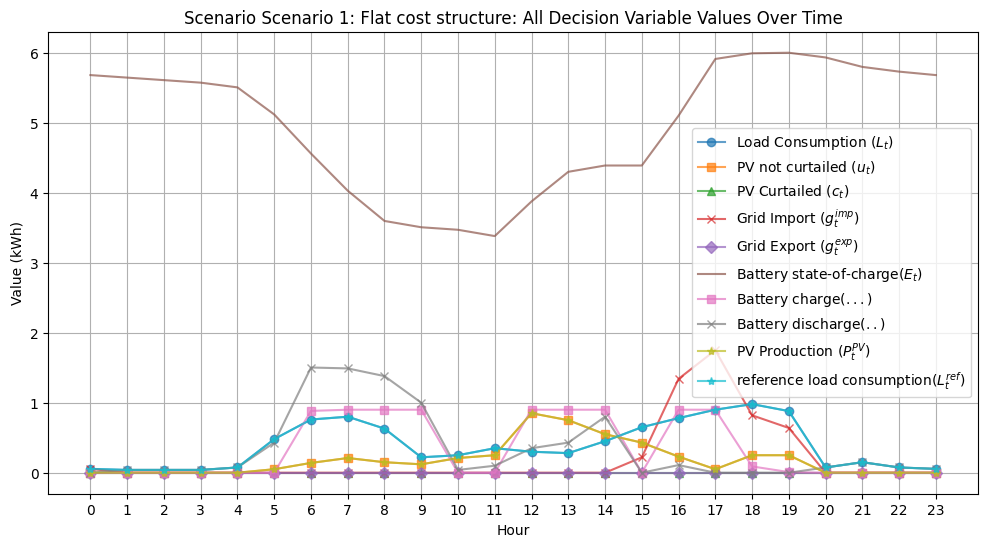

📊 1c-scenario-01-EnergyPriceVsGrid.png


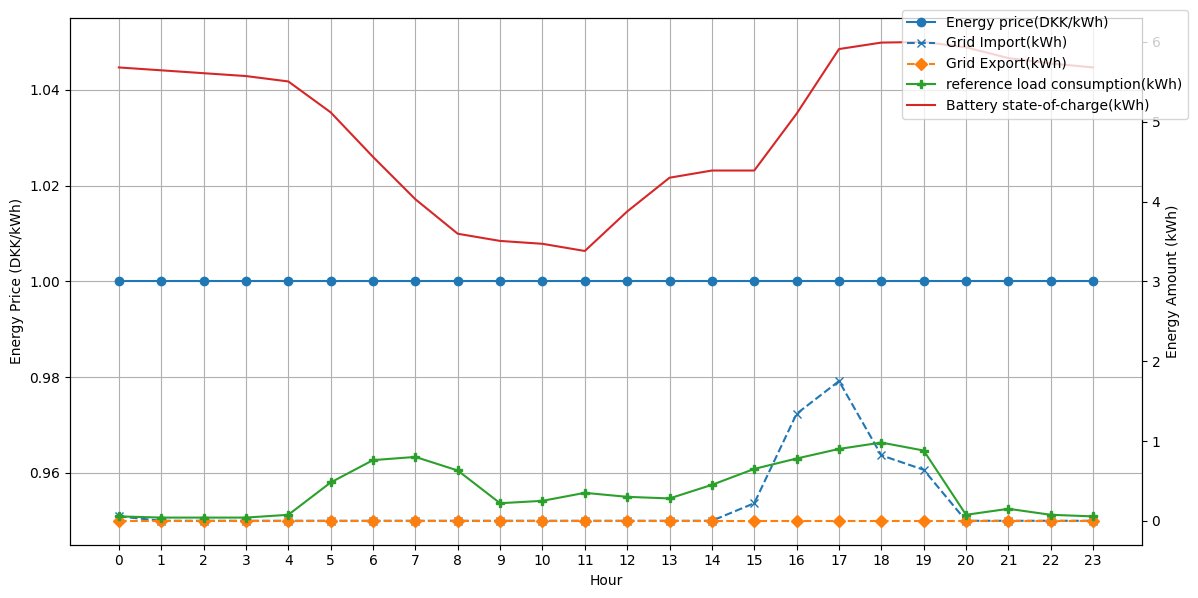

📊 1c-scenario-02-AllDecisionVariables.png


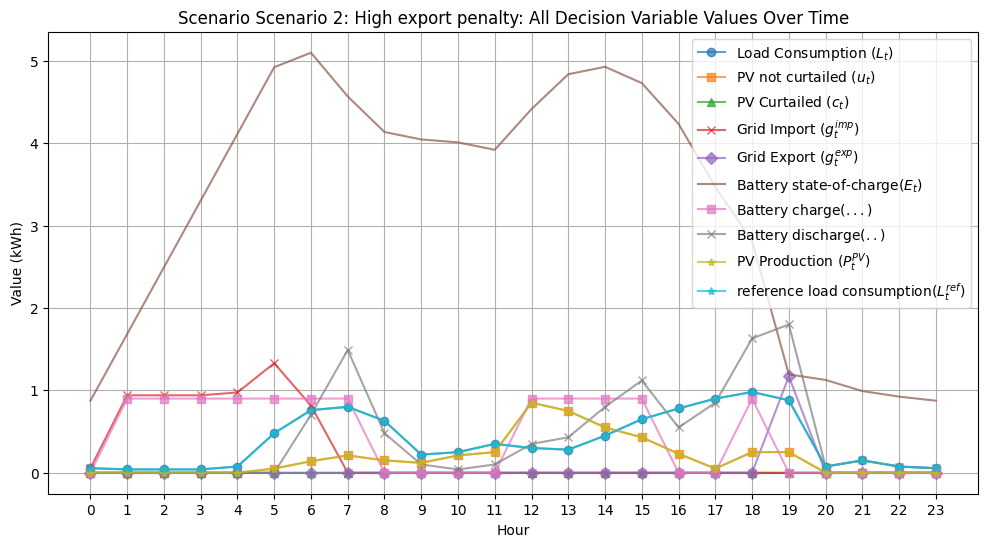

📊 1c-scenario-02-EnergyPriceVsGrid.png


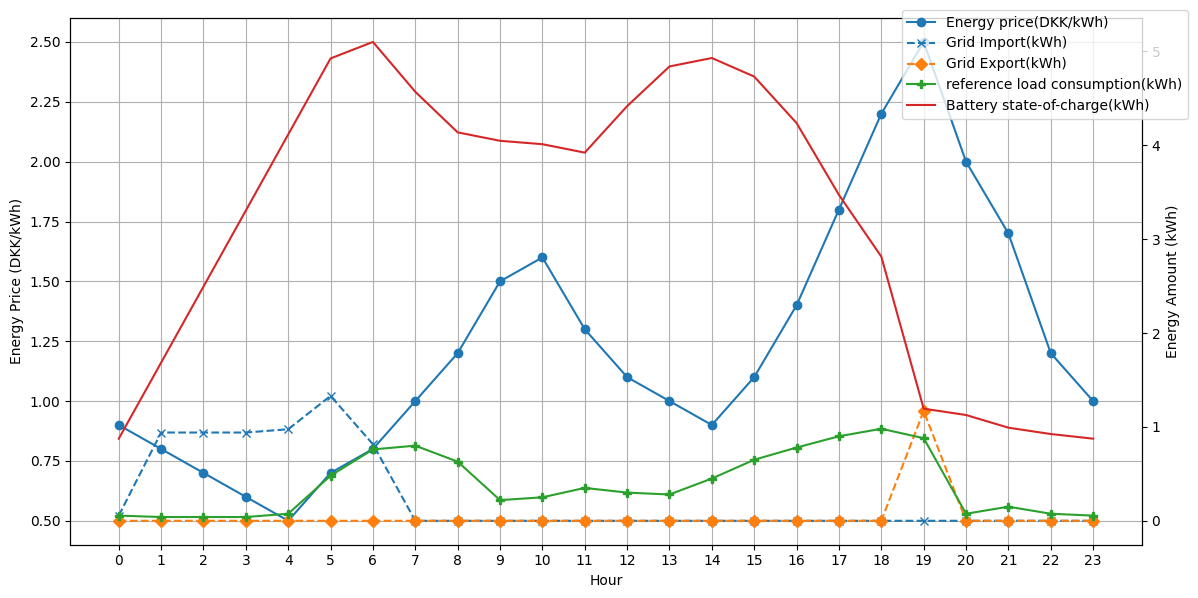

📊 1c-scenario-03-AllDecisionVariables.png


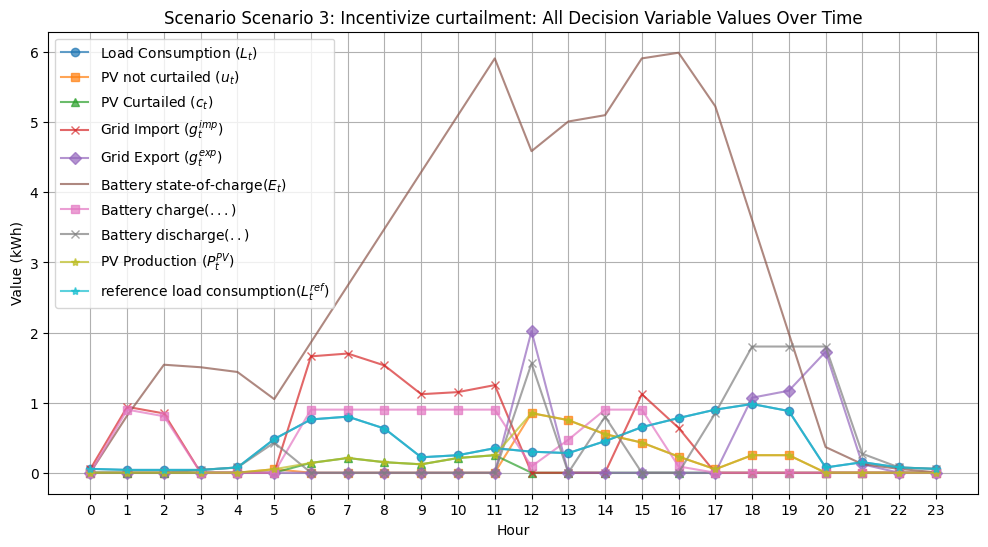

📊 1c-scenario-03-EnergyPriceVsGrid.png


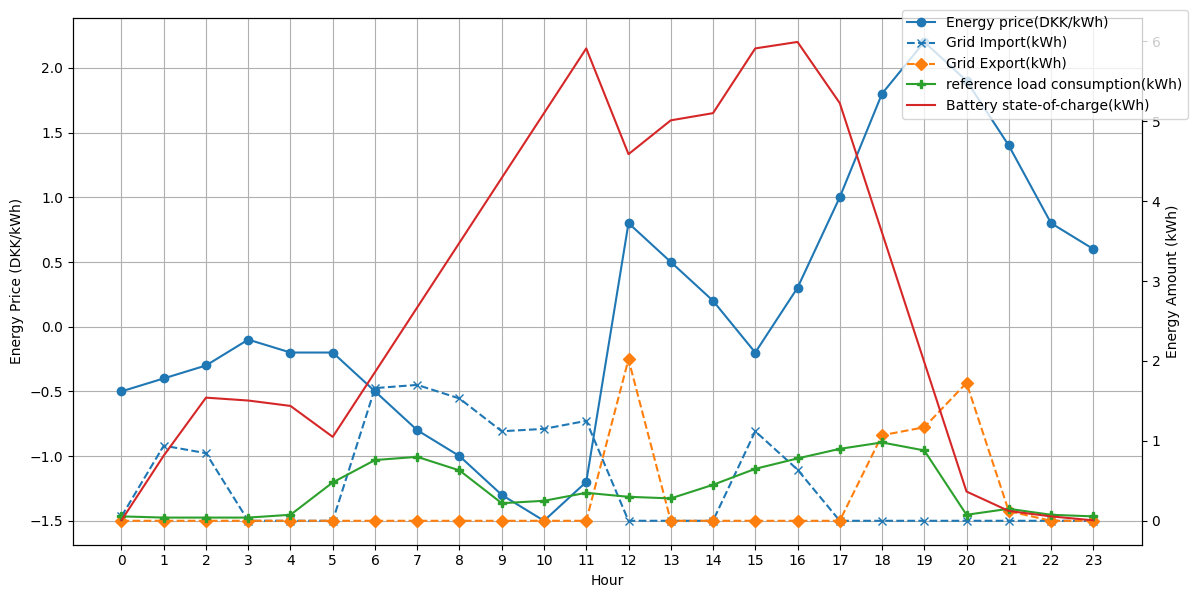

📊 1c-scenario-04-AllDecisionVariables.png


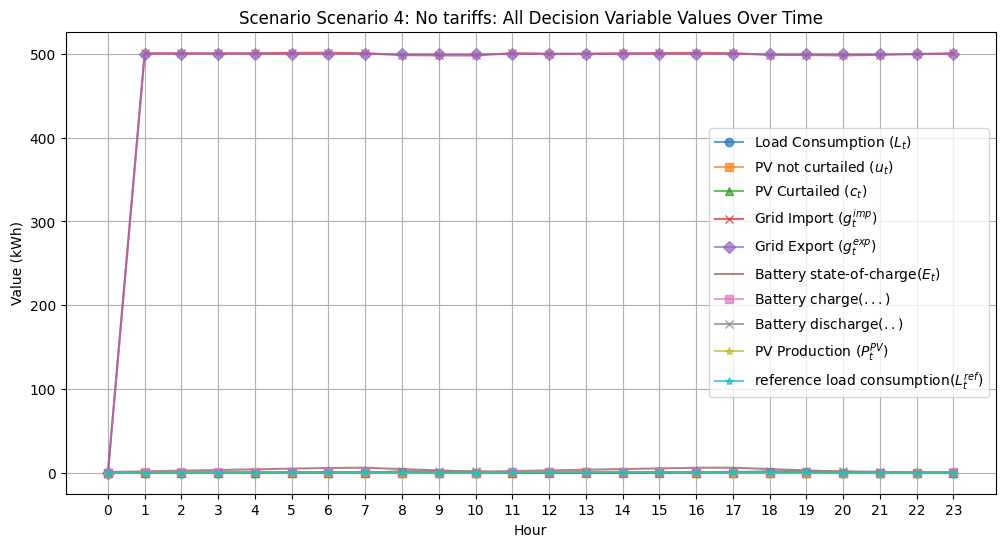

📊 1c-scenario-04-EnergyPriceVsGrid.png


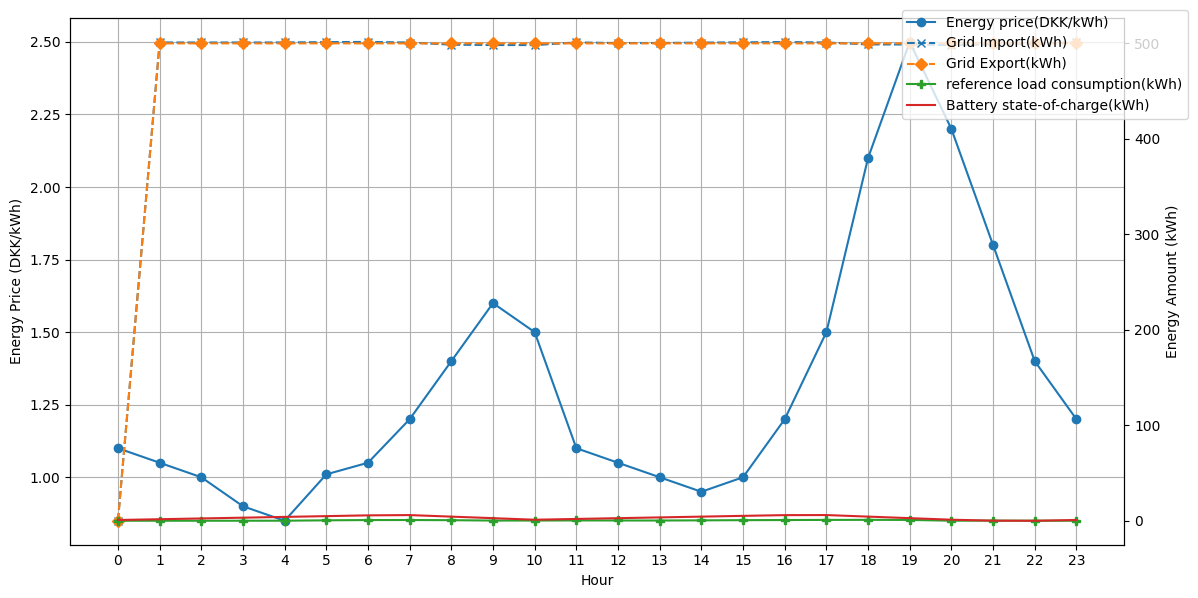

In [7]:
# %%
import glob
from IPython.display import Image, display
image_files = sorted(glob.glob(os.path.join(results_folder, "1c-scenario-*.png")))
if not image_files:
    print("No plots found. Run the scenarios cell first.")
else:
    for img_path in image_files:
        print(f"📊 {os.path.basename(img_path)}")
        display(Image(filename=img_path))
